# Some tests of glove dependency!

In [84]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

In [69]:
import numpy as np
import npp

def get_glove_embedding(dim):
    with open('glove.6B/glove.6B.%dd.txt'%dim, 'r') as f:
        lines = f.readlines()
    glove = {}
    for line in lines:
        parts = line.split(' ')
        parts[-1] = parts[-1].replace('\n', '')
        flag = True
        for word in parts[0]:
            for c in word:
                if c not in 'abcdefghijklmnopqrstuvwxyz' and c != '-' and c!= "'":
                    flag = False
                    break
        if flag:
            glove[parts[0]] = np.array(list(map(float, parts[1:])))
            assert glove[parts[0]].shape[0] == dim
    glove = {word: glove[word]/np.linalg.norm(glove[word]) for word in glove}
    glove['oov'] = np.zeros(dim)
    return glove

In [2]:
glove = get_glove_embedding(50)

In [3]:
len(glove)

336674

In [4]:
transcript = open('monkey.txt').read().split(" ")

In [5]:
len(transcript)

4790

In [6]:
print("Average words per second: %0.3f" % (len(transcript) / (30 * 60)))

Average words per second: 2.661


In [9]:
wordvectors = np.array([glove.get(w.lower().strip(",."), np.zeros(50)) for w in transcript])
prev_words = wordvectors[:-1]
next_words = wordvectors[1:]

In [10]:
wordvectors.shape

(4790, 50)

In [59]:
len(prev_words[4000:])

789

## Fit model that predicts glove(word_{i-1}) from glove(word_i)

In [24]:
# fit using first 4000 words
wt,rank,res,sing = np.linalg.lstsq(next_words[:4000], prev_words[:4000])

# test on last 789 words
pred_prev = next_words[4000:].dot(wt)

# compute correlation for each word
corrs = np.array([np.corrcoef(p,pp)[0,1] for p,pp in zip(prev_words[4000:], pred_prev)])

/Users/huth/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


Text(0.5,0,'Corr(predicted glove(word i) from glove(word i+1), glove(word i))')

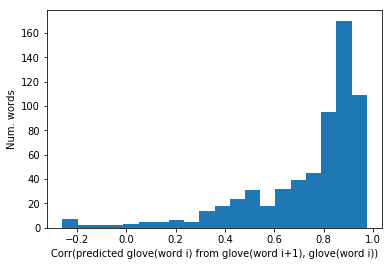

In [61]:
plt.hist(corrs[~np.isnan(corrs)], 20)
plt.ylabel("Num. words")
plt.xlabel("Corr(predicted glove(word i) from glove(word i+1), glove(word i))")

These values are clearly WAY above chance!

In [40]:
# what if we test by looking at the correlation _across_ words for each glove dimension?
corrs2 = np.array([np.corrcoef(p,pp)[0,1] for p,pp in zip(prev_words[4000:].T, pred_prev.T)])

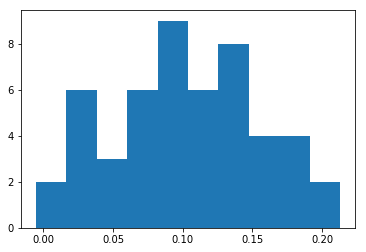

In [42]:
# also clearly above chance
plt.hist(corrs2, 10);

# What if we used random vectors instead of glove?

In [34]:
rand_vectors = {w: np.random.randn(50) for w in glove.keys()}

In [35]:
randwordvectors = np.array([rand_vectors.get(w.lower().strip(",."), np.zeros(50)) for w in transcript])
rand_prev_words = randwordvectors[:-1]
rand_next_words = randwordvectors[1:]

In [62]:
# fit model that predicts rand_embedding(word i-1) from rand_embedding(word i)
randwt,randrank,randres,randsing = np.linalg.lstsq(rand_next_words[:4000], rand_prev_words[:4000])
rand_pred_prev = rand_next_words[4000:].dot(randwt)
randcorrs = np.array([np.corrcoef(p,pp)[0,1] for p,pp in zip(rand_prev_words[4000:], rand_pred_prev)])
randcorrs2 = np.array([np.corrcoef(p,pp)[0,1] for p,pp in zip(rand_prev_words[4000:].T, rand_pred_prev.T)])

/Users/huth/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.
/Users/huth/anaconda3/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/huth/anaconda3/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


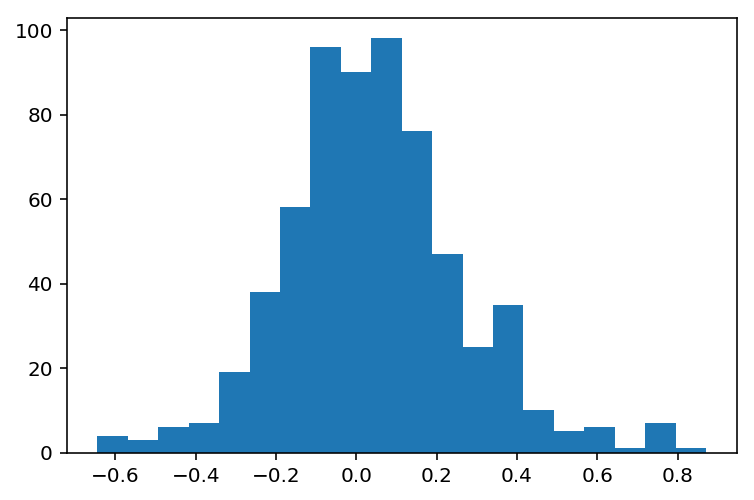

In [86]:
# this looks much closer to zero, but is there still significant information?
plt.hist(randcorrs[~np.isnan(randcorrs)], 20);

In [77]:
# significance test.....
nperm = 1000
perm_ccs = np.zeros(nperm)
for ii in range(nperm):
    permwt = np.random.permutation(randwt)
    perm_rand_pred_prev = rand_next_words[4000:].dot(permwt)
    #perm_randcorrs = np.array([np.corrcoef(p,pp)[0,1] for p,pp in zip(rand_prev_words[4000:], perm_rand_pred_prev)])
    perm_randcorrs = np.nanmean(npp.mcorr(rand_prev_words[4000:].T, perm_rand_pred_prev.T))
    perm_ccs[ii] = np.nanmean(perm_randcorrs)

/Users/huth/code/notebook-sharing/npp.py:11: RuntimeWarning: invalid value encountered in true_divide
  zscore = lambda v: (v-v.mean(0))/v.std(0)


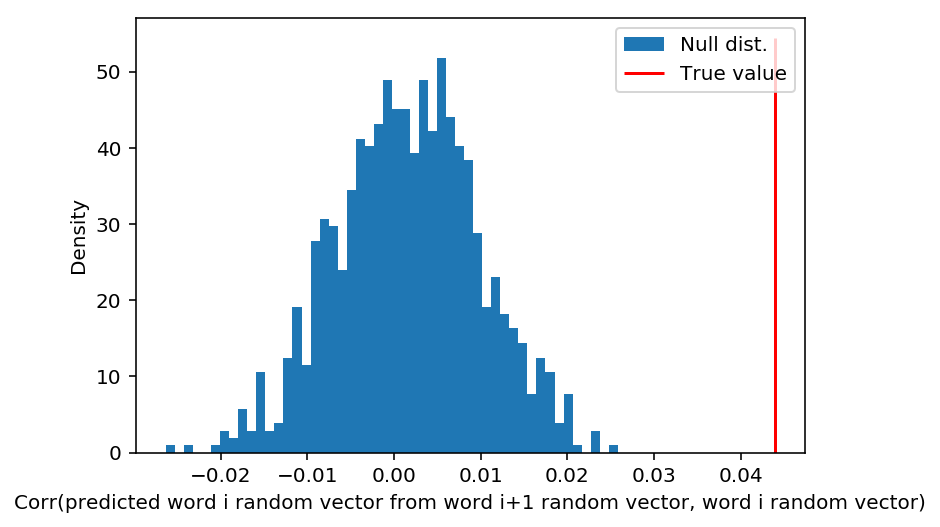

In [85]:
plt.figure(facecolor="white")
plt.hist(perm_ccs, 50, label="Null dist.", density=True);
plt.vlines(np.nanmean(randcorrs), 0, plt.ylim()[1], label="True value", color="red")
plt.xlabel("Corr(predicted word i random vector from word i+1 random vector, word i random vector)")
plt.ylabel("Density")
plt.legend()

# Yeah this looks really significant!

## Use random vector to predict glove vectors?

In [46]:
# fit model that predicts glove(word i-1) from random_emb(word i)
rand2wt,rand2rank,rand2res,rand2sing = np.linalg.lstsq(rand_next_words[:4000], prev_words[:4000])
rand2_pred_prev = rand_next_words[4000:].dot(rand2wt)
rand2corrs = np.array([np.corrcoef(p,pp)[0,1] for p,pp in zip(prev_words[4000:], rand2_pred_prev)])
rand2corrs2 = np.array([np.corrcoef(p,pp)[0,1] for p,pp in zip(prev_words[4000:].T, rand2_pred_prev.T)])

/Users/huth/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.
/Users/huth/anaconda3/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/huth/anaconda3/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Text(0.5,0,'Corr(predicted word i glove vector from word i+1 random vector, word i glove vector)')

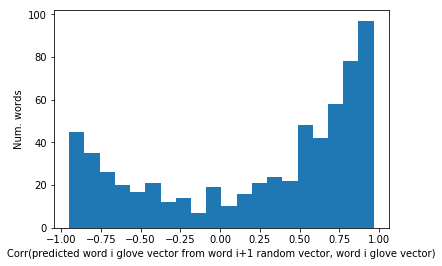

In [50]:
plt.hist(rand2corrs[~np.isnan(rand2corrs)], 20);
plt.ylabel("Num. words")
plt.xlabel("Corr(predicted word i glove vector from word i+1 random vector, word i glove vector)")

Definitely positive on average!

## Regress previous word vector out of next word vector, then try the same?

In [56]:
# predict glove(word i) from glove(word i-1)
nextwt,_,_,_ = np.linalg.lstsq(prev_words[:4000], next_words[:4000])

# subtract prediction to get glove(word i) "independent of" glove(word i-1)
next_words_sub = next_words - prev_words.dot(nextwt)

# fit model that predicts glove(word i-1) using the modified vectors from above
subwt,subrank,subres,subsing = np.linalg.lstsq(next_words_sub[:4000], prev_words[:4000])
subpred_prev = next_words_sub[4000:].dot(subwt)
subcorrs = np.array([np.corrcoef(p,pp)[0,1] for p,pp in zip(prev_words[4000:], subpred_prev)])
subcorrs2 = np.array([np.corrcoef(p,pp)[0,1] for p,pp in zip(prev_words[4000:].T, subpred_prev.T)])

/Users/huth/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.
/Users/huth/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """
/Users/huth/anaconda3/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/huth/anaconda3/anaconda3/lib/p

Text(0.5,0,'Corr(pred. glove(word i) from glove(word i+1) - pred. glove(word i+1) from word i, word i glove vector)')

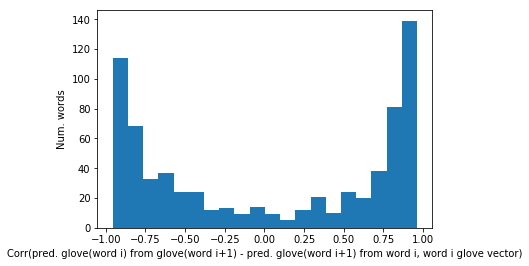

In [60]:
plt.hist(subcorrs[~np.isnan(subcorrs)], 20);
plt.ylabel("Num. words")
plt.xlabel("Corr(pred. glove(word i) from glove(word i+1) - pred. glove(word i+1) from word i, word i glove vector)")

In [58]:
subcorrs[~np.isnan(subcorrs)].mean()

0.033224859033786525